# Solving for the Efficient Frontier in Stock Portfolios

<a href="TODO" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![Banner]()

The Efficient Frontier, a core concept in Harry Markowitz's Modern Portfolio Theory (MPT), is used in quantitative finance to build optimal portfolios that offer the highest expected return for a given level of risk and/or the lowest risk for a given level of return. 

It is constructed by diversifying assets to find the best risk-return trade-off. Which in this article, through python and free financial data we will find the optimal portfolio weights, that maximize expected return while minimizing portfolio variance. The result universe of assets should lie on the efficient frontier.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


In [8]:
tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA',
        'INTC', 'CSCO', 'IBM', 'ORCL', 'CRM', 'ADBE']
oil = ['XOM', 'CVX', 'COP', 'OXY', 'SLB', 'HAL',
       'PBR', 'PSX', 'EOG', 'VLO', 'MPC', 'APA']
finance = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS',
           'BK', 'SCHW', 'AXP', 'USB', 'PNC', 'MET']
healthcare = ['JNJ', 'PFE', 'MRK', 'UNH', 'TMO',
              'ABBV', 'LLY', 'AMGN', 'MDT', 'BMY', 'ABT', 'DHR']
transport = ['UNP', 'FDX', 'UPS', 'CSX', 'JBLU',
             'LUV', 'DAL', 'AAL', 'UAL', 'ALK', 'SAVE', 'R']
communication = ['T', 'VZ', 'CMCSA', 'CHTR', 'NFLX',
                 'TMUS', 'LUMN', 'DISH', 'IRM', 'QRVO', 'CIEN']
entertainment = ['NFLX', 'DIS', 'CMCSA', 'EA',
                 'ATVI', 'TTWO', 'ROKU', 'WYNN', 'CHDN', 'PANW', 'TREE']

tickers = tech + oil + finance + healthcare + \
    transport + communication + entertainment


START_DATE = '2021-01-04'
END_DATE = '2023-10-31'


tickers_df = load_ticker_prices_ts_df(
    tickers, START_DATE, END_DATE)
tickers_df = tickers_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

tickers_df.shape, tickers_df.head(2)

((710, 81),
                          AAPL      MSFT      GOOG      AMZN      TSLA  \
 2021-01-05 00:00:00  0.012364  0.000965  0.007337  0.010004  0.007317   
 2021-01-06 00:00:00 -0.033661 -0.025929 -0.003234 -0.024897  0.028390   
 
                          NVDA      INTC      CSCO       IBM      ORCL  ...  \
 2021-01-05 00:00:00  0.022210  0.018925  0.000455  0.017751 -0.012392  ...   
 2021-01-06 00:00:00 -0.058953  0.009682  0.009550  0.024972 -0.002392  ...   
 
                          NFLX       DIS     CMCSA        EA      TTWO  \
 2021-01-05 00:00:00 -0.003940  0.004277 -0.005967  0.012974  0.014318   
 2021-01-06 00:00:00 -0.038998  0.003811  0.011605 -0.031984 -0.015678   
 
                          ROKU      WYNN      CHDN      PANW      TREE  
 2021-01-05 00:00:00  0.054357  0.030776  0.042730 -0.004294  0.000658  
 2021-01-06 00:00:00  0.023182  0.005990  0.046223 -0.013908 -0.056871  
 
 [2 rows x 81 columns])

Calculate the return vector, which the is the average cummulative returns, annualized:

$$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + R_i) \right)^{\frac{N}{n}} - 1 $$
- `n` represents the number of data points or periods in your time series.
- `Ri` represents the returns for each period. we `+1` to get the absolute returns.
- `N` is the total number of trading days in a year (usually 252 for daily returns).

We annualized to scale up the returns to represent a full year of risk/return:
- Daily return: `0.005` (0.5% return)
- Annualized return: `0.005 * 252 = 1.26` (126% annualized return)

In [9]:
TRADING_DAYS_IN_YEAR = 252

rets = ((
    1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR/len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR
rets[:4] * 100.0

AAPL    10.869172
MSFT    17.835692
GOOG    14.243124
AMZN    -6.282798
dtype: float64

In [10]:
cov_matrix.iloc[:4, :4]

,AAPL,MSFT,GOOG,AMZN
AAPL,0.080485,0.058251,0.060955,0.065856
MSFT,0.058251,0.080334,0.066656,0.072414
GOOG,0.060955,0.066656,0.103657,0.082514
AMZN,0.065856,0.072414,0.082514,0.145744


Now we define the investable universe using the Merton Matrix Model.
The Merton Model, is used to estimate the probability of default of a company:

- Determine the inverse of the covariance matrix, denoted as `inv_cov_matrix`, which is essential for various risk and return calculations.
- Calculate the risk vector, `risk_vect` - to evaluate risk and expected returns.
- Calculate the expected return vector, `expect_ret_vect` - also to evaluate risk and expected returns.

In additon, 3 metrics to evaluate the assets combinations:

1. **Constant Return:** We found that the expected return of the portfolio is given by `rets_constant`. This represents the total expected return of the portfolio when each asset's weight is set to an equal amount.

2. **Linear Return:** The linear expected return, denoted as `rets_linear`, quantifies the portfolio's expected return when assets are weighted proportionally to their individual expected returns.

3. **Quadratic Return:** The quadratic expected return, `rets_quadratic`, represents the expected return of the portfolio when assets are allocated based on their risk levels.

Finally, we assessed the scaling parameter, `scaling_param`, which indicates the trade-off between risk and return in the portfolio. This parameter is a crucial consideration in portfolio optimization and asset allocation.

In [11]:
ones = np.ones(len(rets))  # e
inv_cov_matrix = np.linalg.inv(cov_matrix)

risk_vect = np.matmul(ones, inv_cov_matrix)  # h
expect_ret_vect = np.matmul(rets, inv_cov_matrix)  # g

rets_constant = np.sum(ones * risk_vect)  # a
rets_linear = np.sum(rets * risk_vect)  # b
rets_quadratic = np.sum(rets * expect_ret_vect)  # c
scaling_param = rets_quadratic * rets_constant - rets_linear ** 2


mvp = risk_vect / rets_constant
mvp_ret = rets_linear / rets_constant
mvp_risk = (1 / rets_constant) ** (1 / 2)

tan = expect_ret_vect / rets_linear
tan_ret = rets_quadratic / rets_linear
tan_risk = rets_quadratic ** (1 / 2) / rets_linear

exp_rets = np.arange(-0.1, 5, 0.001)
risk = ((rets_constant * exp_rets ** 2 - 2 * rets_linear *

        exp_rets + rets_quadratic) / scaling_param) ** (1 / 2)


tickers[:4], mvp[:4], tan[:4]

(['AAPL', 'MSFT', 'GOOG', 'AMZN'],
 array([-0.06031692,  0.0794481 , -0.00968459, -0.00953051]),
 array([-0.0693086 ,  0.84013112,  0.22805207, -0.30430458]))

Now lets build 2 portfolios that will set the boundaries:
1. Minimum variance portfolio - he MVP the tip of the frontier.
2. Tangency portfolio - Market portfolio in CAPM and is the hpoint of tageny and the secutiries markett line.

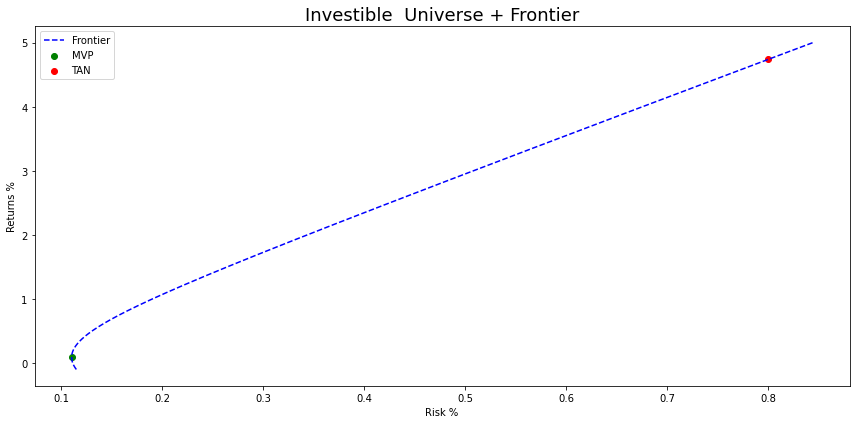

In [12]:


plt.figure(figsize=(12, 6))
plt.title(f'Investible  Universe + Frontier', fontsize=18)
plt.plot(risk,  exp_rets, linestyle='--', label='Frontier', color='blue', )
plt.scatter(mvp_risk, mvp_ret, label='MVP', color='green')
plt.scatter(tan_risk, tan_ret, label='TAN', color='red')
plt.legend(loc='upper left', fontsize=10)
plt.xlabel('Risk %')
plt.ylabel('Returns %')
plt.tight_layout()
plt.show()

# Conclusion

TODO

![footer]()

## References

- https://www.investopedia.com/terms/m/mertonmodel.asp
- https://mathworld.wolfram.com/MatrixInverse.html


## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/oscilators-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/trading-oscillators-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.